# 시계열 데이터를 이용한 딥러닝 예측
## RNN 해보기

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd

import time
import myplot

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import plot_model

In [ ]:
#!pip install sklearn

# Basic RNNs

### Generate the Dataset

In [2]:
def generate_time_series(batch_size, n_steps):        
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    
    time = np.linspace(0, 1, n_steps)    
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2    
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise    
    return series[..., np.newaxis].astype(np.float32)


In [3]:
np.random.seed(42)

n_steps = 50

series = generate_time_series(1000, n_steps + 1)

X_train, y_train = series[:700, :n_steps], series[:700, -1]
X_valid, y_valid = series[700:900, :n_steps], series[700:900, -1]
X_test, y_test = series[900:, :n_steps], series[900:, -1]

In [4]:
X_train.shape, y_train.shape, X_valid.shape

((700, 50, 1), (700, 1), (200, 50, 1))

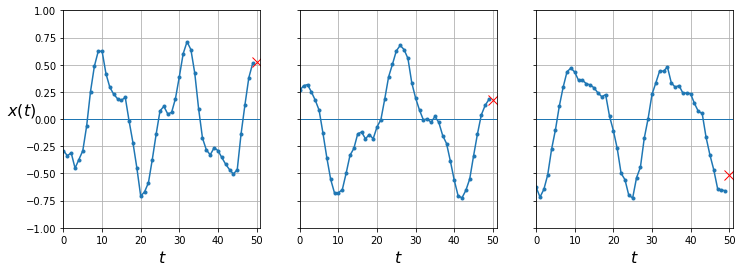

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    myplot.plot_series(n_steps, X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None))

plt.show()

In [6]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.023199858

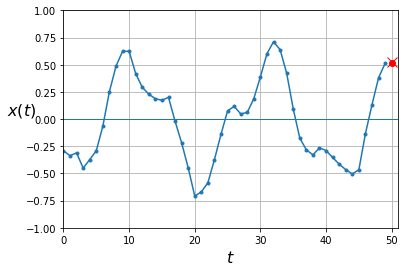

In [7]:
myplot.plot_series(n_steps,X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

### Computing Some Baselines

Naive predictions (just predict the last observed value):

In [8]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.023199858

- 아래 그림을 잘 그리기 위해서 'n_steps'을 plot_series에 추가 해주었다.  

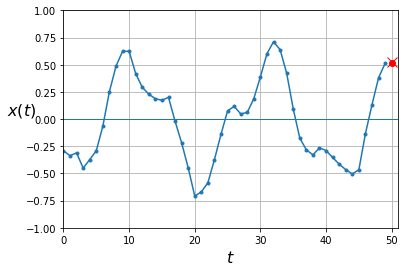

In [9]:
myplot.plot_series(n_steps,X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

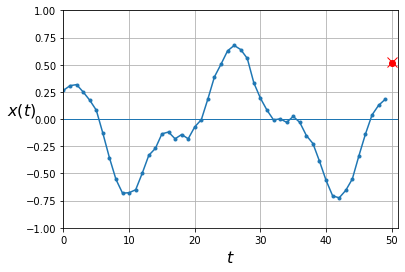

In [10]:
myplot.plot_series(n_steps, X_valid[1, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

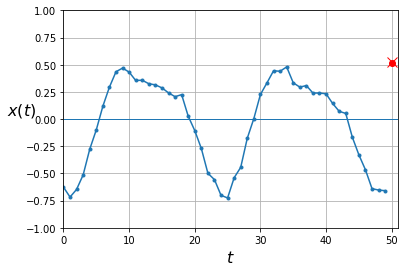

In [11]:
myplot.plot_series(n_steps,X_valid[2, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## a1. 선형 예측 

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model_flatten = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model=model_flatten

model.compile(loss="mse", optimizer="adam")

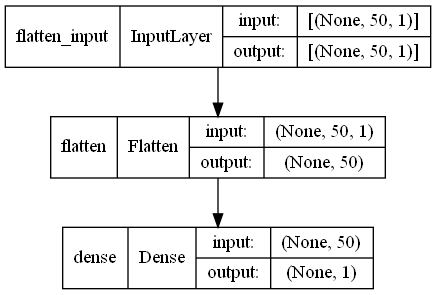

In [13]:
plot_model(model, to_file='./a1_model_Flatten.png', show_shapes=True)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [15]:
%%time
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
22/22 [==============================] - 1s 10ms/step - loss: 0.1944 - val_loss: 0.1687
Epoch 2/20
22/22 [==============================] - 0s 4ms/step - loss: 0.1458 - val_loss: 0.1343
Epoch 3/20
22/22 [==============================] - 0s 3ms/step - loss: 0.1179 - val_loss: 0.1127
Epoch 4/20
22/22 [==============================] - 0s 3ms/step - loss: 0.1008 - val_loss: 0.0976
Epoch 5/20
22/22 [==============================] - 0s 3ms/step - loss: 0.0884 - val_loss: 0.0866
Epoch 6/20
22/22 [==============================] - 0s 2ms/step - loss: 0.0788 - val_loss: 0.0768
Epoch 7/20
22/22 [==============================] - 0s 2ms/step - loss: 0.0707 - val_loss: 0.0693
Epoch 8/20
22/22 [==============================] - 0s 2ms/step - loss: 0.0641 - val_loss: 0.0625
Epoch 9/20
22/22 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0568
Epoch 10/20
22/22 [==============================] - 0s 2ms/step - loss: 0.0534 - val_loss: 0.0520
Epoch 11/20
22/22 

In [16]:
model.evaluate(X_valid, y_valid)

7/7 [==============================] - 0s 1ms/step - loss: 0.0250


0.024977831169962883

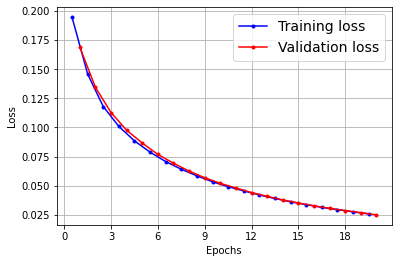

In [17]:
myplot.plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

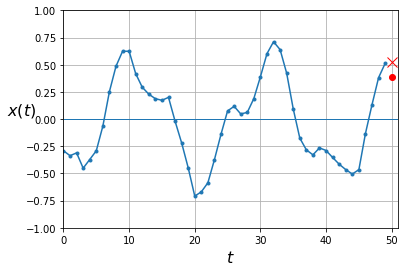

In [18]:
y_pred = model.predict(X_valid)
myplot.plot_series(n_steps, X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [19]:
a1 = history.history['loss'][np.argmin(history.history['loss'])]
print('The loss of basics', a1)

The loss of basics 0.025886598974466324


## a2. Simple RNN

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

simpleRNN = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

model = simpleRNN
optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss="mse", optimizer=optimizer)

C:\Users\admin\Anaconda3\envs\tf-cpu\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


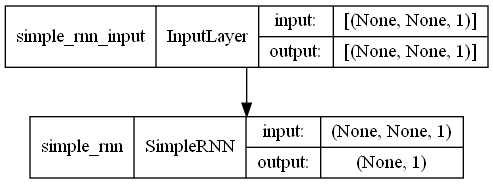

In [21]:
plot_model(model, to_file='./a2_model_simpleRNN.png', show_shapes=True)


In [22]:
%%time
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
22/22 [==============================] - 1s 21ms/step - loss: 0.2486 - val_loss: 0.2051
Epoch 2/20
22/22 [==============================] - 0s 10ms/step - loss: 0.1573 - val_loss: 0.1301
Epoch 3/20
22/22 [==============================] - 0s 14ms/step - loss: 0.1047 - val_loss: 0.0969
Epoch 4/20
22/22 [==============================] - 0s 18ms/step - loss: 0.0850 - val_loss: 0.0845
Epoch 5/20
22/22 [==============================] - 0s 11ms/step - loss: 0.0761 - val_loss: 0.0771
Epoch 6/20
22/22 [==============================] - 0s 15ms/step - loss: 0.0692 - val_loss: 0.0714
Epoch 7/20
22/22 [==============================] - 0s 15ms/step - loss: 0.0632 - val_loss: 0.0647
Epoch 8/20
22/22 [==============================] - 0s 12ms/step - loss: 0.0585 - val_loss: 0.0596
Epoch 9/20
22/22 [==============================] - 0s 11ms/step - loss: 0.0539 - val_loss: 0.0562
Epoch 10/20
22/22 [==============================] - 0s 14ms/step - loss: 0.0502 - val_loss: 0.0518
Epoch 11/

In [23]:
model.evaluate(X_valid, y_valid)

7/7 [==============================] - 0s 5ms/step - loss: 0.0323


0.03233329951763153

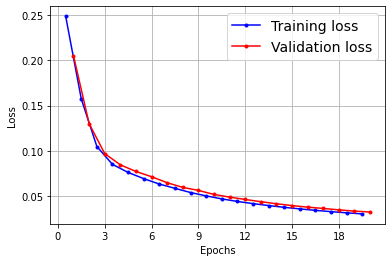

In [24]:
myplot.plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

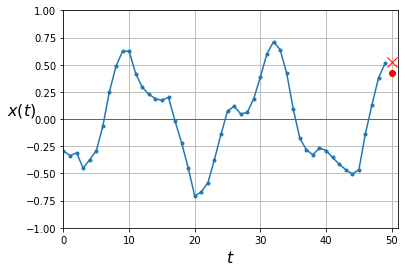

In [25]:
y_pred = model.predict(X_valid)
myplot.plot_series(n_steps, X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [26]:
a2 = history.history['loss'][np.argmin(history.history['loss'])]
print('The loss of SimpleRNN model', a2)

The loss of SimpleRNN model 0.030235184356570244


## a3. Deep RNNs

In [27]:
np.random.seed(42)
tf.random.set_seed(42)

deepRNN = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model = deepRNN
model.compile(loss="mse", optimizer="adam")

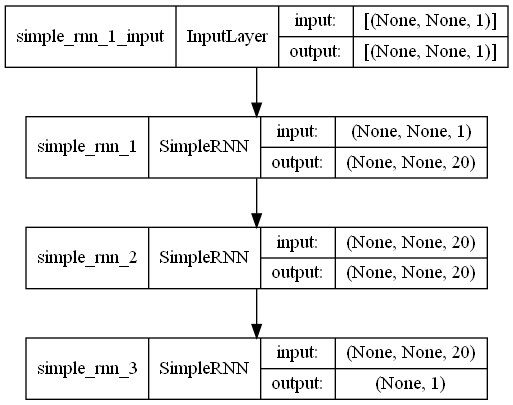

In [28]:
plot_model(model, to_file='./a3_model_deepRNN.png', show_shapes=True)


In [29]:
%%time
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
22/22 [==============================] - 3s 46ms/step - loss: 0.2733 - val_loss: 0.0891
Epoch 2/20
22/22 [==============================] - 1s 30ms/step - loss: 0.0743 - val_loss: 0.0400
Epoch 3/20
22/22 [==============================] - 1s 30ms/step - loss: 0.0348 - val_loss: 0.0239
Epoch 4/20
22/22 [==============================] - 1s 33ms/step - loss: 0.0252 - val_loss: 0.0187
Epoch 5/20
22/22 [==============================] - 1s 30ms/step - loss: 0.0169 - val_loss: 0.0154
Epoch 6/20
22/22 [==============================] - 1s 32ms/step - loss: 0.0146 - val_loss: 0.0137
Epoch 7/20
22/22 [==============================] - 1s 30ms/step - loss: 0.0128 - val_loss: 0.0101
Epoch 8/20
22/22 [==============================] - 1s 32ms/step - loss: 0.0102 - val_loss: 0.0114
Epoch 9/20
22/22 [==============================] - 1s 38ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 10/20
22/22 [==============================] - 1s 38ms/step - loss: 0.0080 - val_loss: 0.0087
Epoch 11/

In [30]:
model.evaluate(X_valid, y_valid)

7/7 [==============================] - 0s 12ms/step - loss: 0.0077


0.007704524323344231

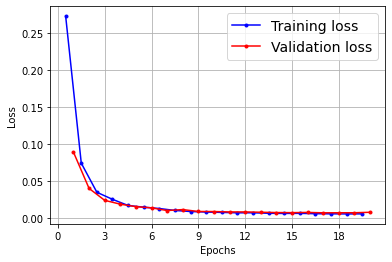

In [31]:
myplot.plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

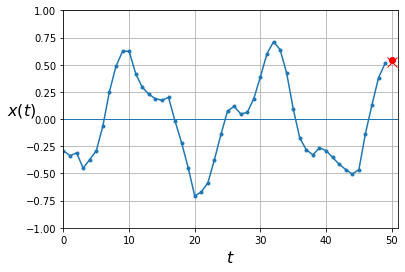

In [32]:
y_pred = model.predict(X_valid)
myplot.plot_series(n_steps, X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [33]:
a3 = history.history['loss'][np.argmin(history.history['loss'])]
print('The loss of deepRNN model', a3)

The loss of deepRNN model 0.005486132111400366


## a4. Deep RNN with layer return only the last output:

In [34]:
np.random.seed(42)
tf.random.set_seed(42)

deepRNNDense = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model = deepRNNDense

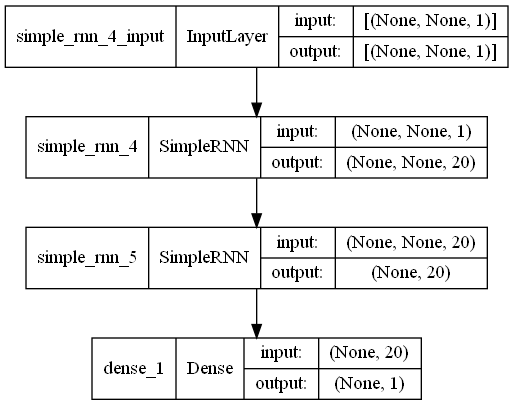

In [35]:
plot_model(model, to_file='./a4_model_deepRNNDense.png', show_shapes=True)

In [36]:
model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
22/22 [==============================] - 2s 40ms/step - loss: 0.1155 - val_loss: 0.0630
Epoch 2/20
22/22 [==============================] - 1s 27ms/step - loss: 0.0438 - val_loss: 0.0282
Epoch 3/20
22/22 [==============================] - 1s 31ms/step - loss: 0.0217 - val_loss: 0.0169
Epoch 4/20
22/22 [==============================] - 1s 30ms/step - loss: 0.0141 - val_loss: 0.0116
Epoch 5/20
22/22 [==============================] - 1s 33ms/step - loss: 0.0103 - val_loss: 0.0094
Epoch 6/20
22/22 [==============================] - 1s 29ms/step - loss: 0.0082 - val_loss: 0.0086
Epoch 7/20
22/22 [==============================] - 1s 28ms/step - loss: 0.0072 - val_loss: 0.0069
Epoch 8/20
22/22 [==============================] - 1s 24ms/step - loss: 0.0064 - val_loss: 0.0068
Epoch 9/20
22/22 [==============================] - 1s 24ms/step - loss: 0.0058 - val_loss: 0.0059
Epoch 10/20
22/22 [==============================] - 1s 24ms/step - loss: 0.0053 - val_loss: 0.0053
Epoch 11/

In [37]:
model.evaluate(X_valid, y_valid)

7/7 [==============================] - 0s 9ms/step - loss: 0.0040


0.003982017748057842

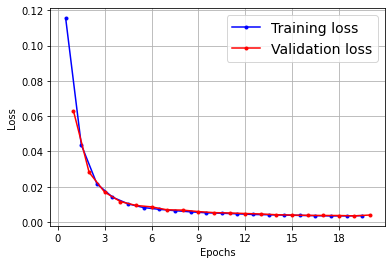

In [38]:
myplot.plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

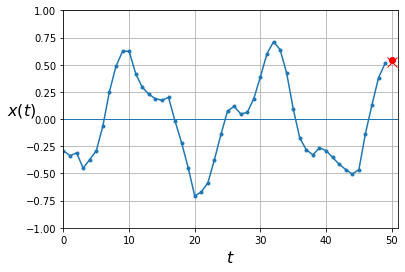

In [39]:
y_pred = model.predict(X_valid)
myplot.plot_series(n_steps, X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

In [40]:
a4 = history.history['loss'][np.argmin(history.history['loss'])]
print('The loss of DeepRNNDense model', a4)

The loss of DeepRNNDense model 0.003472351236268878


# Results Summary

In [42]:
models = pd.DataFrame({
    'Model': ['Flatten',  'SimpleRNN','DeepRNN','DeepRNNDense'],
    'Score': [a1, a2, a3, a4]})
models.sort_values(by='Score', ascending=True)

,Model,Score
3,DeepRNNDense,0.003472
2,DeepRNN,0.005486
0,Flatten,0.025887
1,SimpleRNN,0.030235
